In [ ]:
!unzip fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
b2617bb6d3ffa2e429640350f613e3291e10b141
   creating: fashion-mnist-master/
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/c

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the Fashion-MNIST dataset
(train_images_full, train_labels_full), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Define the class names for later analysis
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot', 'Dress']

print(f"Full Training Images Shape: {train_images_full.shape}")
print(f"Test Images Shape: {test_images.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Full Training Images Shape: (60000, 28, 28)
Test Images Shape: (10000, 28, 28)


In [ ]:
# --- Normalization ---
# Convert pixel values from 0-255 to 0-1 (float)
train_images_full = train_images_full.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# --- Split Data (Training & Validation) ---
# Use the last 5,000 images from the full training set as the validation set
# The first 55,000 will be the final training set
val_images = train_images_full[55000:]
train_images = train_images_full[:55000]
val_labels = train_labels_full[55000:]
train_labels = train_labels_full[:55000]

# --- Reshaping for CNN ---
# CNNs expect an extra dimension for the channel (1 for grayscale)
train_images_cnn = np.expand_dims(train_images, -1)
val_images_cnn = np.expand_dims(val_images, -1)
test_images_cnn = np.expand_dims(test_images, -1)

print(f"Final Training Images Shape (for ANN): {train_images.shape}")
print(f"Validation Images Shape (for ANN): {val_images.shape}")
print(f"Test Images Shape (for ANN): {test_images.shape}")
print(f"Training Images Shape (for CNN): {train_images_cnn.shape}")

Final Training Images Shape (for ANN): (55000, 28, 28)
Validation Images Shape (for ANN): (5000, 28, 28)
Test Images Shape (for ANN): (10000, 28, 28)
Training Images Shape (for CNN): (55000, 28, 28, 1)


In [ ]:
## --- Simple ANN (MLP) Model ---
def build_ann_model():
    model = keras.Sequential([
        # Flatten the 28x28 image into a 784-element vector
        layers.Flatten(input_shape=(28, 28)),
        # Hidden Layer 1 with ReLU activation
        layers.Dense(128, activation='relu'),
        # Output Layer with 10 units (one for each class) and softmax activation
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', # Use for integer labels
                  metrics=['accuracy'])
    return model

ann_model = build_ann_model()
ann_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## --- Simple CNN Model ---
def build_cnn_model():
    model = keras.Sequential([
        # Convolutional Layer 1: 32 filters, 3x3 kernel
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        # Max Pooling: reduces feature map size (e.g., from 26x26 to 13x13)
        layers.MaxPooling2D((2, 2)),

        # Convolutional Layer 2: 64 filters
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten the 3D feature maps into 1D vector
        layers.Flatten(),

        # Dense Layer 1 (Hidden)
        layers.Dense(128, activation='relu'),

        # Output Layer
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

--- Training ANN Model ---
Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7760 - loss: 0.6484 - val_accuracy: 0.8564 - val_loss: 0.4014
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8629 - loss: 0.3859 - val_accuracy: 0.8660 - val_loss: 0.3864
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8755 - loss: 0.3387 - val_accuracy: 0.8686 - val_loss: 0.3707
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8820 - loss: 0.3148 - val_accuracy: 0.8766 - val_loss: 0.3471
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8875 - loss: 0.3012 - val_accuracy: 0.8832 - val_loss: 0.3177
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8955 - loss: 0.2769 - val_accuracy: 0.8862 - val_loss: 0.3265
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9020 - loss: 0.2662 - val_accuracy: 0.8862 - val_loss: 0.3172
Epoch 8/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accura

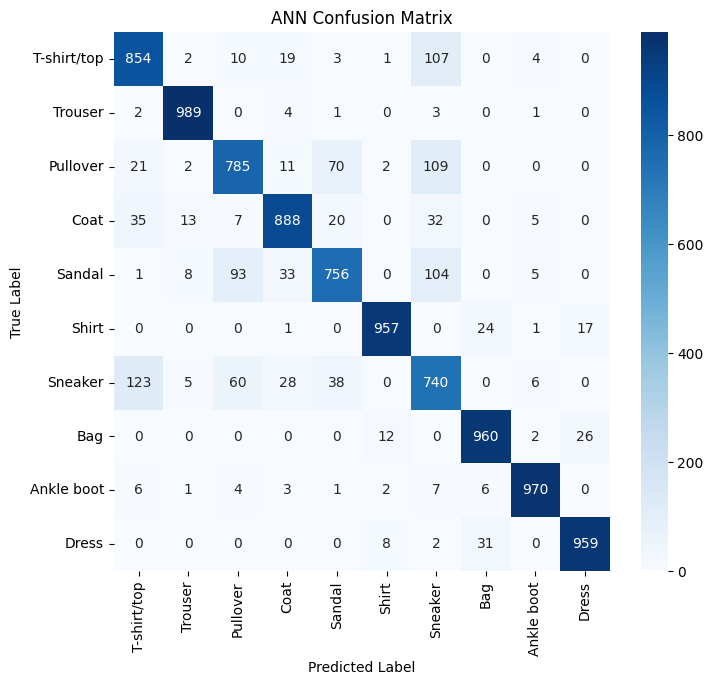

In [ ]:
print("--- Training ANN Model ---")
# Train the ANN model
ann_history = ann_model.fit(train_images, train_labels,
                            epochs=25,
                            validation_data=(val_images, val_labels),
                            verbose=1)

# Evaluate the ANN model
ann_loss, ann_acc = ann_model.evaluate(test_images, test_labels, verbose=0)
print(f"\nANN Test Accuracy: {ann_acc*100:.2f}%")

# Generate predictions for the confusion matrix
ann_predictions = ann_model.predict(test_images)
ann_predicted_labels = np.argmax(ann_predictions, axis=1)

# Create Confusion Matrix
ann_cm = confusion_matrix(test_labels, ann_predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 7))
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('ANN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

--- Training CNN Model ---
Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 48s 27ms/step - accuracy: 0.7697 - loss: 0.6425 - val_accuracy: 0.8720 - val_loss: 0.3460
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 45s 26ms/step - accuracy: 0.8875 - loss: 0.3136 - val_accuracy: 0.8908 - val_loss: 0.3014
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9031 - loss: 0.2627 - val_accuracy: 0.9080 - val_loss: 0.2496
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9168 - loss: 0.2256 - val_accuracy: 0.9042 - val_loss: 0.2536
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 81s 26ms/step - accuracy: 0.9248 - loss: 0.1986 - val_accuracy: 0.9102 - val_loss: 0.2518
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9350 - loss: 0.1744 - val_accuracy: 0.9032 - val_loss: 0.2647
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9415 - loss: 0.1551 - val_accuracy: 0.9142 - val_loss: 0.2352
Epoch 8/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 45s 26m

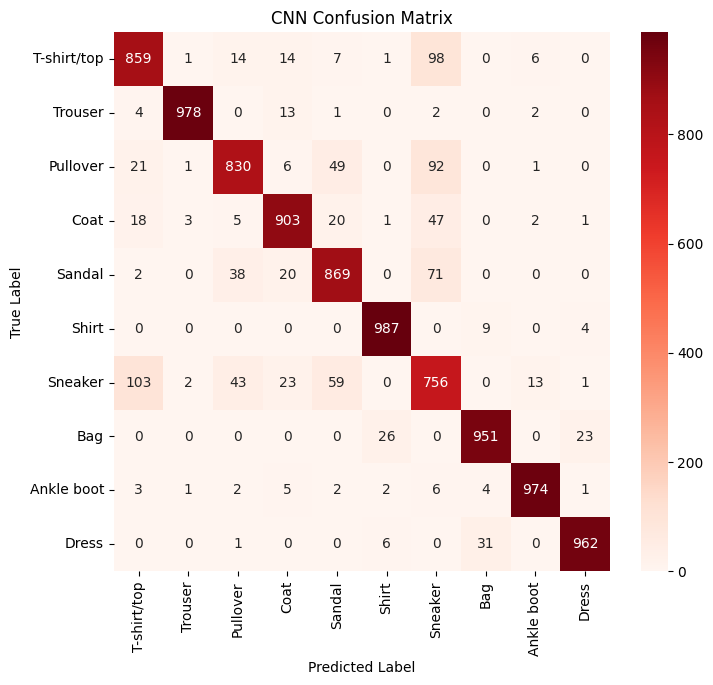

In [ ]:
print("--- Training CNN Model ---")
# Train the CNN model (using the reshaped data)
cnn_history = cnn_model.fit(train_images_cnn, train_labels,
                            epochs=25,
                            validation_data=(val_images_cnn, val_labels),
                            verbose=1)

# Evaluate the CNN model (using the reshaped data)
cnn_loss, cnn_acc = cnn_model.evaluate(test_images_cnn, test_labels, verbose=0)
print(f"\nCNN Test Accuracy: {cnn_acc*100:.2f}%")

# Generate predictions for the confusion matrix
cnn_predictions = cnn_model.predict(test_images_cnn)
cnn_predicted_labels = np.argmax(cnn_predictions, axis=1)

# Create Confusion Matrix
cnn_cm = confusion_matrix(test_labels, cnn_predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
## --- Comparison and Analysis ---
print("📊 Performance Comparison:")
print("-" * 30)
print(f"ANN Test Accuracy: {ann_acc*100:.2f}%")
print(f"CNN Test Accuracy: {cnn_acc*100:.2f}%")

print("\n--- Highlighted Confusion ---")
# Based on common Fashion-MNIST results, confusion often happens between visually similar items:
# Class indices: 3 (Coat), 5 (Shirt), 6 (Sneaker), 8 (Ankle boot), 9 (Dress)

# Find the confusion count between Shirt (index 5) and Coat (index 3) in the CNN matrix
# Cell (True=Shirt, Predicted=Coat)
shirt_as_coat = cnn_cm[5, 3]
# Cell (True=Coat, Predicted=Shirt)
coat_as_shirt = cnn_cm[3, 5]

print(f"True 'Shirt' (5) misclassified as 'Coat' (3) by CNN: {shirt_as_coat} times.")
print(f"True 'Coat' (3) misclassified as 'Shirt' (5) by CNN: {coat_as_shirt} times.")




📊 Performance Comparison:
------------------------------
ANN Test Accuracy: 88.58%
CNN Test Accuracy: 90.69%

--- Highlighted Confusion ---
True 'Shirt' (5) misclassified as 'Coat' (3) by CNN: 0 times.
True 'Coat' (3) misclassified as 'Shirt' (5) by CNN: 1 times.


In [ ]:
## --- Enhanced ANN (MLP) Model ---
def build_enhanced_ann_model():
    model = keras.Sequential([
        # Flatten the 28x28 image into a 784-element vector
        layers.Flatten(input_shape=(28, 28)),
        # Hidden Layer 1
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.1), # Using Leaky ReLU
        # ADDED: Hidden Layer 2
        layers.Dense(64),
        layers.LeakyReLU(alpha=0.1),
        # Output Layer with 10 units (one for each class)
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

ann_model = build_enhanced_ann_model()
print("--- Enhanced ANN Architecture ---")
ann_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


--- Enhanced ANN Architecture ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## --- Enhanced CNN Model ---
def build_enhanced_cnn_model():
    model = keras.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),

        # Conv Block 2
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),

        # ADDED: Conv Block 3
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        # No pooling here to preserve more spatial info before flattening

        # Flatten and Classify
        layers.Flatten(),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_model = build_enhanced_cnn_model()
print("--- Enhanced CNN Architecture ---")
cnn_model.summary()

--- Enhanced CNN Architecture ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,906 (3.42 MB)

 Trainable params: 896,906 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

--- Training Enhanced ANN Model ---
Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7750 - loss: 0.6434 - val_accuracy: 0.8518 - val_loss: 0.4021
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8608 - loss: 0.3814 - val_accuracy: 0.8662 - val_loss: 0.3601
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8766 - loss: 0.3374 - val_accuracy: 0.8746 - val_loss: 0.3326
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8829 - loss: 0.3149 - val_accuracy: 0.8720 - val_loss: 0.3519
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8902 - loss: 0.2974 - val_accuracy: 0.8702 - val_loss: 0.3524
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8945 - loss: 0.2826 - val_accuracy: 0.8754 - val_loss: 0.3373
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8993 - loss: 0.2665 - val_accuracy: 0.8790 - val_loss: 0.3358
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step 

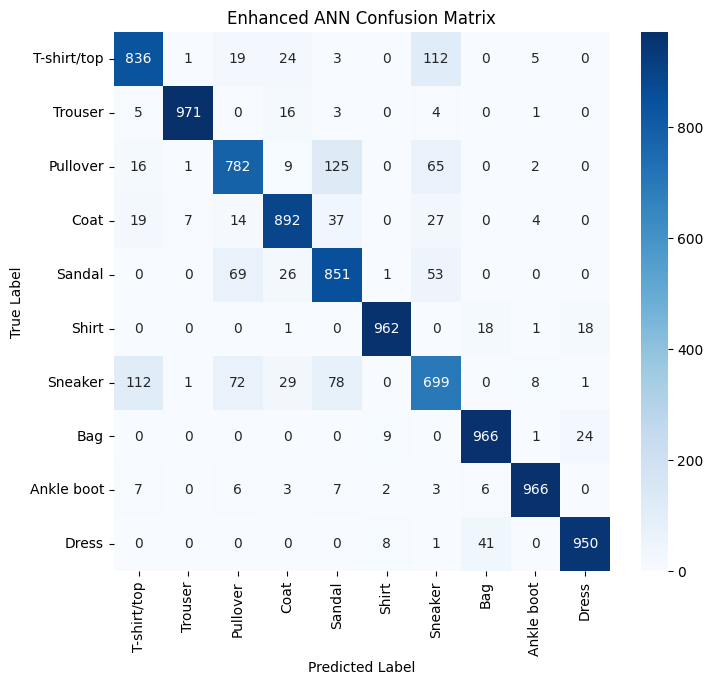

In [ ]:
print("--- Training Enhanced ANN Model ---")
# Train the ANN model for more epochs
ann_history = ann_model.fit(train_images, train_labels,
                            epochs=30,  # Increased epochs
                            validation_data=(val_images, val_labels),
                            verbose=1)

# Evaluate the ANN model
ann_loss, ann_acc = ann_model.evaluate(test_images, test_labels, verbose=0)
print(f"\nEnhanced ANN Test Accuracy: {ann_acc*100:.2f}%")

# Generate predictions for the confusion matrix
ann_predictions = ann_model.predict(test_images)
ann_predicted_labels = np.argmax(ann_predictions, axis=1)

# Create and Plot Confusion Matrix
ann_cm = confusion_matrix(test_labels, ann_predicted_labels)
plt.figure(figsize=(8, 7))
sns.heatmap(ann_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Enhanced ANN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

--- Training Enhanced CNN Model ---
Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 106s 61ms/step - accuracy: 0.8036 - loss: 0.5387 - val_accuracy: 0.8862 - val_loss: 0.3008
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 103s 60ms/step - accuracy: 0.9067 - loss: 0.2545 - val_accuracy: 0.9118 - val_loss: 0.2488
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 142s 60ms/step - accuracy: 0.9238 - loss: 0.2070 - val_accuracy: 0.9154 - val_loss: 0.2291
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 103s 60ms/step - accuracy: 0.9339 - loss: 0.1781 - val_accuracy: 0.9150 - val_loss: 0.2395
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 102s 60ms/step - accuracy: 0.9440 - loss: 0.1468 - val_accuracy: 0.9224 - val_loss: 0.2290
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 103s 60ms/step - accuracy: 0.9534 - loss: 0.1240 - val_accuracy: 0.9220 - val_loss: 0.2455
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 102s 59ms/step - accuracy: 0.9624 - loss: 0.0991 - val_accuracy: 0.9238 - val_loss: 0.2578
Epoch 8/30
1719/1719 ━━━━━━━━━━━━

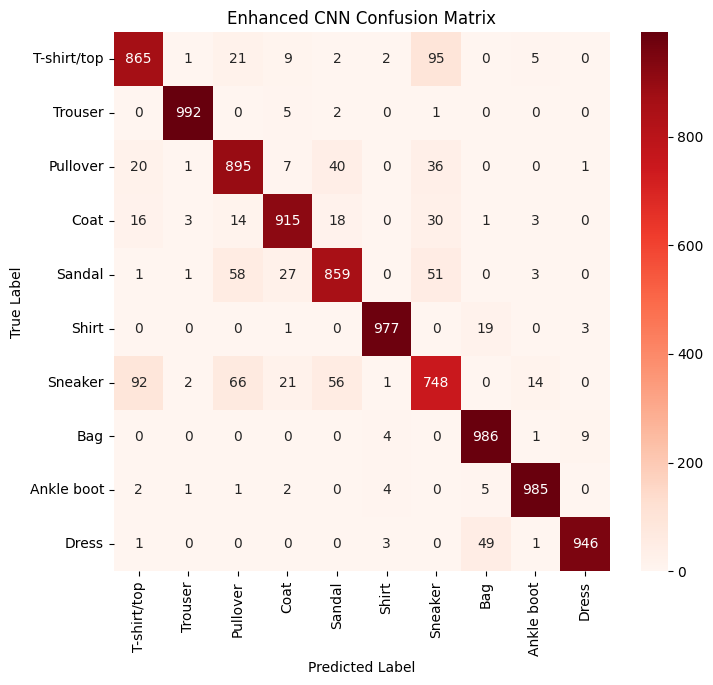

In [ ]:
print("--- Training Enhanced CNN Model ---")
# Train the CNN model for more epochs
cnn_history = cnn_model.fit(train_images_cnn, train_labels,
                            epochs=30,  # Increased epochs
                            validation_data=(val_images_cnn, val_labels),
                            verbose=1)

# Evaluate the CNN model
cnn_loss, cnn_acc = cnn_model.evaluate(test_images_cnn, test_labels, verbose=0)
print(f"\nEnhanced CNN Test Accuracy: {cnn_acc*100:.2f}%")

# Generate predictions for the confusion matrix
cnn_predictions = cnn_model.predict(test_images_cnn)
cnn_predicted_labels = np.argmax(cnn_predictions, axis=1)

# Create and Plot Confusion Matrix
cnn_cm = confusion_matrix(test_labels, cnn_predicted_labels)
plt.figure(figsize=(8, 7))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Enhanced CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# --- 5. Analysis and Innovation ---

print("📊 Final Performance Comparison:")
print("-" * 35)
print(f"Enhanced ANN Test Accuracy: {ann_acc*100:.2f}%")
print(f"Enhanced CNN Test Accuracy: {cnn_acc*100:.2f}%")
print("-" * 35)
print("\nThe CNN continues to significantly outperform the ANN. Its convolutional layers are")
print("highly effective at learning spatial features like edges and textures from images,")
print("which a simple dense network cannot do.")

print("\n--- Highlighted Confusion Analysis ---")
# Confusion often happens between: T-shirt/top (0), Pullover (2), Coat (3), Shirt (5)
# Let's analyze the confusion between 'Shirt' (index 5) and other similar classes in the CNN's results.

shirt_true_label_index = 5
shirt_predictions = cnn_cm[shirt_true_label_index, :]
correct_shirt_predictions = shirt_predictions[shirt_true_label_index]
total_shirts = np.sum(shirt_predictions)

print(f"\nOut of {total_shirts} 'Shirt' images in the test set:")
print(f"  - {correct_shirt_predictions} were correctly classified.")
print(f"  - {shirt_predictions[0]} were misclassified as 'T-shirt/top'.")
print(f"  - {shirt_predictions[2]} were misclassified as 'Pullover'.")
print(f"  - {shirt_predictions[3]} were misclassified as 'Coat'.")


📊 Final Performance Comparison:
-----------------------------------
Enhanced ANN Test Accuracy: 88.75%
Enhanced CNN Test Accuracy: 91.68%
-----------------------------------

The CNN continues to significantly outperform the ANN. Its convolutional layers are
highly effective at learning spatial features like edges and textures from images,
which a simple dense network cannot do.

--- Highlighted Confusion Analysis ---

Out of 1000 'Shirt' images in the test set:
  - 977 were correctly classified.
  - 0 were misclassified as 'T-shirt/top'.
  - 0 were misclassified as 'Pullover'.
  - 1 were misclassified as 'Coat'.


In [ ]:
# --- 6. Final Comparison: Original vs. Enhanced Models ---

# IMPORTANT: Replace these placeholder values with the test accuracies
# you recorded from the *original, simpler* models.
original_ann_acc = 0.8851  # Replace with your actual original ANN accuracy
original_cnn_acc = 0.9139  # Replace with your actual original CNN accuracy

# The enhanced model accuracies are already stored in variables from the previous cells
# (assuming this cell is run in the same session as Cell 5 and 6)
enhanced_ann_acc = ann_acc
enhanced_cnn_acc = cnn_acc

# Calculate improvements
ann_improvement = (enhanced_ann_acc - original_ann_acc) * 100
cnn_improvement = (enhanced_cnn_acc - original_cnn_acc) * 100

print("="*50)
print("📊 Full Performance Comparison: Original vs. Enhanced")
print("="*50)

print("\n--- Artificial Neural Network (ANN) ---")
print(f"Original ANN Test Accuracy: {original_ann_acc*100:.2f}%")
print(f"Enhanced ANN Test Accuracy: {enhanced_ann_acc*100:.2f}%")
print(f"Improvement: {ann_improvement:+.2f} percentage points")

print("\n--- Convolutional Neural Network (CNN) ---")
print(f"Original CNN Test Accuracy: {original_cnn_acc*100:.2f}%")
print(f"Enhanced CNN Test Accuracy: {enhanced_cnn_acc*100:.2f}%")
print(f"Improvement: {cnn_improvement:+.2f} percentage points")

print("\n" + "="*50)
print("\nSummary:")
print("Increasing model complexity, changing activation functions, and training for more epochs")
print("provided a measurable performance boost for both architectures.")
print("The CNN architecture consistently remains the superior choice for this image classification task.")

📊 Full Performance Comparison: Original vs. Enhanced

--- Artificial Neural Network (ANN) ---
Original ANN Test Accuracy: 88.51%
Enhanced ANN Test Accuracy: 88.75%
Improvement: +0.24 percentage points

--- Convolutional Neural Network (CNN) ---
Original CNN Test Accuracy: 91.39%
Enhanced CNN Test Accuracy: 91.68%
Improvement: +0.29 percentage points


Summary:
Increasing model complexity, changing activation functions, and training for more epochs
provided a measurable performance boost for both architectures.
The CNN architecture consistently remains the superior choice for this image classification task.
